In [1]:
import re
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from seismicpro import Survey, SeismicDataset, SeismicIndex

from seismicpro.batchflow import DatasetIndex, W, B, BA, V
from seismicpro.batchflow.models.torch import UNet, ResBlock

%env CUDA_VISIBLE_DEVICES=1, 5

env: CUDA_VISIBLE_DEVICES=1, 5


In [2]:
%%time
path = './Carich_Kuvaik_line_shot_Pick2.sgy'
picking_path = 'Car_MANUAL_pick_off-3000_50shots'
sur = Survey(path=path, header_index='FieldRecord', header_cols=['FieldRecord', 'TraceNumber', 'offset'], name='raw')
sur.load_first_breaks(picking_path)

CPU times: user 4.32 s, sys: 3.47 s, total: 7.79 s
Wall time: 7.78 s


In [3]:
ix = SeismicIndex(surveys=sur)
ix.split(shuffle=42)

train_ix = ix.train.reindex('TRACE_SEQUENCE_FILE')
dataset_train = SeismicDataset(train_ix)
dataset_test = SeismicDataset(ix.test)

In [4]:
config = {
    'inputs': {'masks': dict(classes=2)},
    'body/encoder/blocks': dict(base=ResBlock, kernel_size=5, filters=[8, 16, 32, 64], attention='scse'),
    'body/decoder/blocks': dict(base=ResBlock, kernel_size=5, filters=[8, 16, 32, 64][::-1], attention='scse'),        
    'body/embedding': dict(filters=128, kernel_size=5),
    'optimizer': ('Adam', {'lr': 0.001}),
    'common/conv/kernel_size': 5,
}

In [5]:
ppl = (dataset_train.p
      .init_variable('loss', [])
      .load(src='raw', fmt='segy', combined=True)
      .scale_standard(src='raw')
      .pick_to_mask(src='raw', dst='raw')
      .init_model('my_model', UNet, 'dynamic', config=config)
      .train_model('my_model', 
                   images=BA('raw').data.transpose((1, 0, 2)),
                   targets=BA('raw').mask.squeeze(),
                   fetches='loss', save_to=V('loss', mode='a'))
      .run_later(100, n_iters=100, drop_last=True, shuffle=42, bar='n', profile=False)
)

In [6]:
%%time
ppl.run()

  0%|                                                                                                         …

../seismicpro/batchflow/batchflow/models/torch/unet.py:104: UserWarning: 'decoder/upsample/filters' are not set and can be inconsistent with 'decoder/blocks/filters'! Please revise your model's config. In future, upsample filters can be made to match decoder block's filters by default.
  "In future, upsample filters can be made to match decoder block's filters by default.")


CPU times: user 1min 50s, sys: 2.68 s, total: 1min 52s
Wall time: 1min 53s


In [7]:
ppl.save_model_now('my_model', path='trained_model_new.dill')

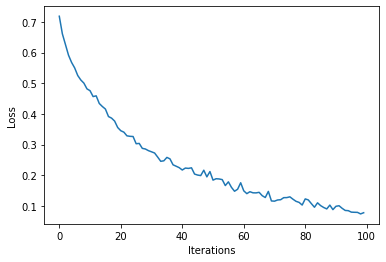

In [8]:
import matplotlib.pyplot as plt
loss = ppl.v('loss')
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.plot(loss)

In [9]:
config_predict = {
    'build': False,
    'load/path':  'trained_model_new.dill',
    'device': 'gpu:1'
}

test_pipeline = (dataset_test.p
    .add_namespace(np)
    .init_model(mode='dynamic', model_class=UNet, name='my_model', config=config_predict) 
    .init_variable('true', [])
    .init_variable('traces', [])
    .init_variable('predictions', [])
    .load(src='raw', fmt='segy', limits=700)
    .sort(src='raw', by='offset')
    .scale_standard(src='raw', dst='raw')
    .update(V('traces', mode='e'), BA('raw').data)
    .update(V('true', mode='e'), BA('raw')['FirstBreak'])
    .make_data(src=BA('raw').data, dst='inputs', concat_axis=0, expand_dims_axis=1)
    .predict_model('my_model', B('inputs'),
                 fetches='predictions', save_to=B('preds'))
    .argmax(B.preds, axis=1, save_to=B('preds'))
    .split_results(src='preds', dst=BA('raw').mask, shapes=BA('raw').shape[:, 0])
    .mask_to_pick(src='raw', dst='raw', first_breaks_col='Predict')
    .update(V('predictions', mode='e'), BA('raw')['Predict'])
)

In [10]:
test_pipeline.run(1, n_epochs=1, drop_last=False, shuffle=False, bar='n')

  0%|                                                                                                         …

In [11]:
true = np.array(test_pipeline.v('true')) 
pred = np.array(test_pipeline.v('predictions'))
traces = np.array(test_pipeline.v('traces'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

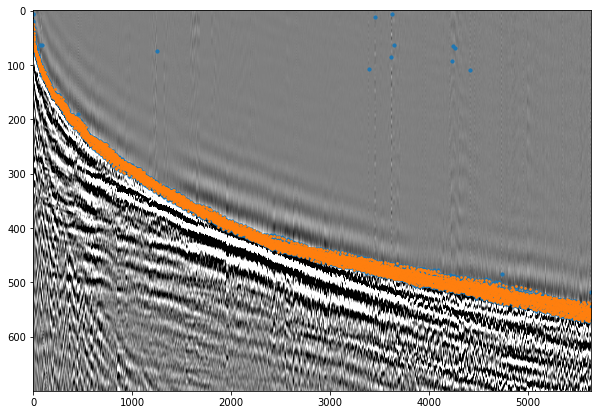

In [12]:
i = 0
plt.figure(figsize=(10, 7))
plt.imshow(traces[i].T, aspect='auto', cmap='gray', vmin=-0.5, vmax=0.5)
plt.scatter(np.arange(len(pred[i])), (pred[i]/2), 10);
plt.scatter(np.arange(len(true[i])), (true[i]/2), 3);

In [13]:
print('MAE, milliseconds: {0:.3f}'.format(np.mean(np.abs(np.concatenate(true)-np.concatenate(pred)))))

MAE, milliseconds: 6.082
